# Loneliness Risk Score (LRS) - Combined Index
## Integrating Social Isolation (LCS) with Environmental Stressors (ES)

This notebook combines:
- **LCS (Loneliness Composite Score)**: Census-based social isolation factors
- **ES (Environmental Stressors)**: Satellite-derived environmental factors

### LRS Formula
```
LRS = 0.50×LCS + 0.50×ES
```

### Output
- LRS_Summer = 0.50×LCS + 0.50×ES_Summer
- LRS_Winter = 0.50×LCS + 0.50×ES_Winter
- Priority zone identification (High LCS + High ES)

In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

print("Libraries imported")

Libraries imported


## 1. Load LCS and ES Data

In [2]:
# Load LCS data (from Pitch 2)
lcs_file = Path('../Pitch2/LCS_NYC_2023.geojson')
gdf_lcs = gpd.read_file(lcs_file)

print(f"LCS data: {len(gdf_lcs)} census tracts")
print(f"LCS columns: {gdf_lcs.columns.tolist()}")
print(f"\nLCS Score range: {gdf_lcs['LCS'].min():.3f} - {gdf_lcs['LCS'].max():.3f}")

LCS data: 2327 census tracts
LCS columns: ['GEOID', 'NAMELSAD', 'COUNTYFP', 'LCS', 'Living_Alone', 'Marital_Status', 'Disability', 'No_Vehicle', 'Limited_English', 'Poverty', 'geometry']

LCS Score range: 0.000 - 0.676


In [3]:
# Load ES data (from this notebook's output)
es_file = Path('../Pitch3/ES_NYC_2023.geojson')
gdf_es = gpd.read_file(es_file)

print(f"ES data: {len(gdf_es)} census tracts")
print(f"\nES Summer range: {gdf_es['ES_Summer'].min():.3f} - {gdf_es['ES_Summer'].max():.3f}")
print(f"ES Winter range: {gdf_es['ES_Winter'].min():.3f} - {gdf_es['ES_Winter'].max():.3f}")

ES data: 2327 census tracts

ES Summer range: 0.016 - 0.974
ES Winter range: 0.029 - 0.874


## 2. Merge LCS and ES Data

In [4]:
# Merge on GEOID
# Keep geometry from LCS, add ES columns
es_cols = ['GEOID', 'ES_Summer', 'ES_Winter', 
           'Temp_Summer', 'Air_Quality_Summer', 'Vegetation_Lack_Summer', 'NTL_Summer',
           'Temp_Winter', 'Air_Quality_Winter', 'Vegetation_Lack_Winter', 'NTL_Winter']

gdf_lrs = gdf_lcs.merge(
    gdf_es[es_cols],
    on='GEOID',
    how='left'
)

print(f"Merged data: {len(gdf_lrs)} census tracts")
print(f"Tracts with both LCS and ES: {gdf_lrs['ES_Summer'].notna().sum()}")

Merged data: 2327 census tracts
Tracts with both LCS and ES: 2327


## 3. Calculate LRS (Summer & Winter)

In [5]:
# LRS = 0.50×LCS + 0.50×ES
# Equal weighting of social isolation and environmental stressors

gdf_lrs['LRS_Summer'] = 0.50 * gdf_lrs['LCS'] + 0.50 * gdf_lrs['ES_Summer']
gdf_lrs['LRS_Winter'] = 0.50 * gdf_lrs['LCS'] + 0.50 * gdf_lrs['ES_Winter']

print("LRS Score Statistics:")
print("\nSummer LRS:")
print(gdf_lrs['LRS_Summer'].describe())
print("\nWinter LRS:")
print(gdf_lrs['LRS_Winter'].describe())

LRS Score Statistics:

Summer LRS:
count    2327.000000
mean        0.365671
std         0.120739
min         0.019177
25%         0.282740
50%         0.368911
75%         0.454052
max         0.796482
Name: LRS_Summer, dtype: float64

Winter LRS:
count    2327.000000
mean        0.365617
std         0.114164
min         0.059895
25%         0.290442
50%         0.384619
75%         0.453618
max         0.698199
Name: LRS_Winter, dtype: float64


## 4. LRS Maps - Summer vs Winter

Saved: LRS_Summer_Winter_Comparison.png


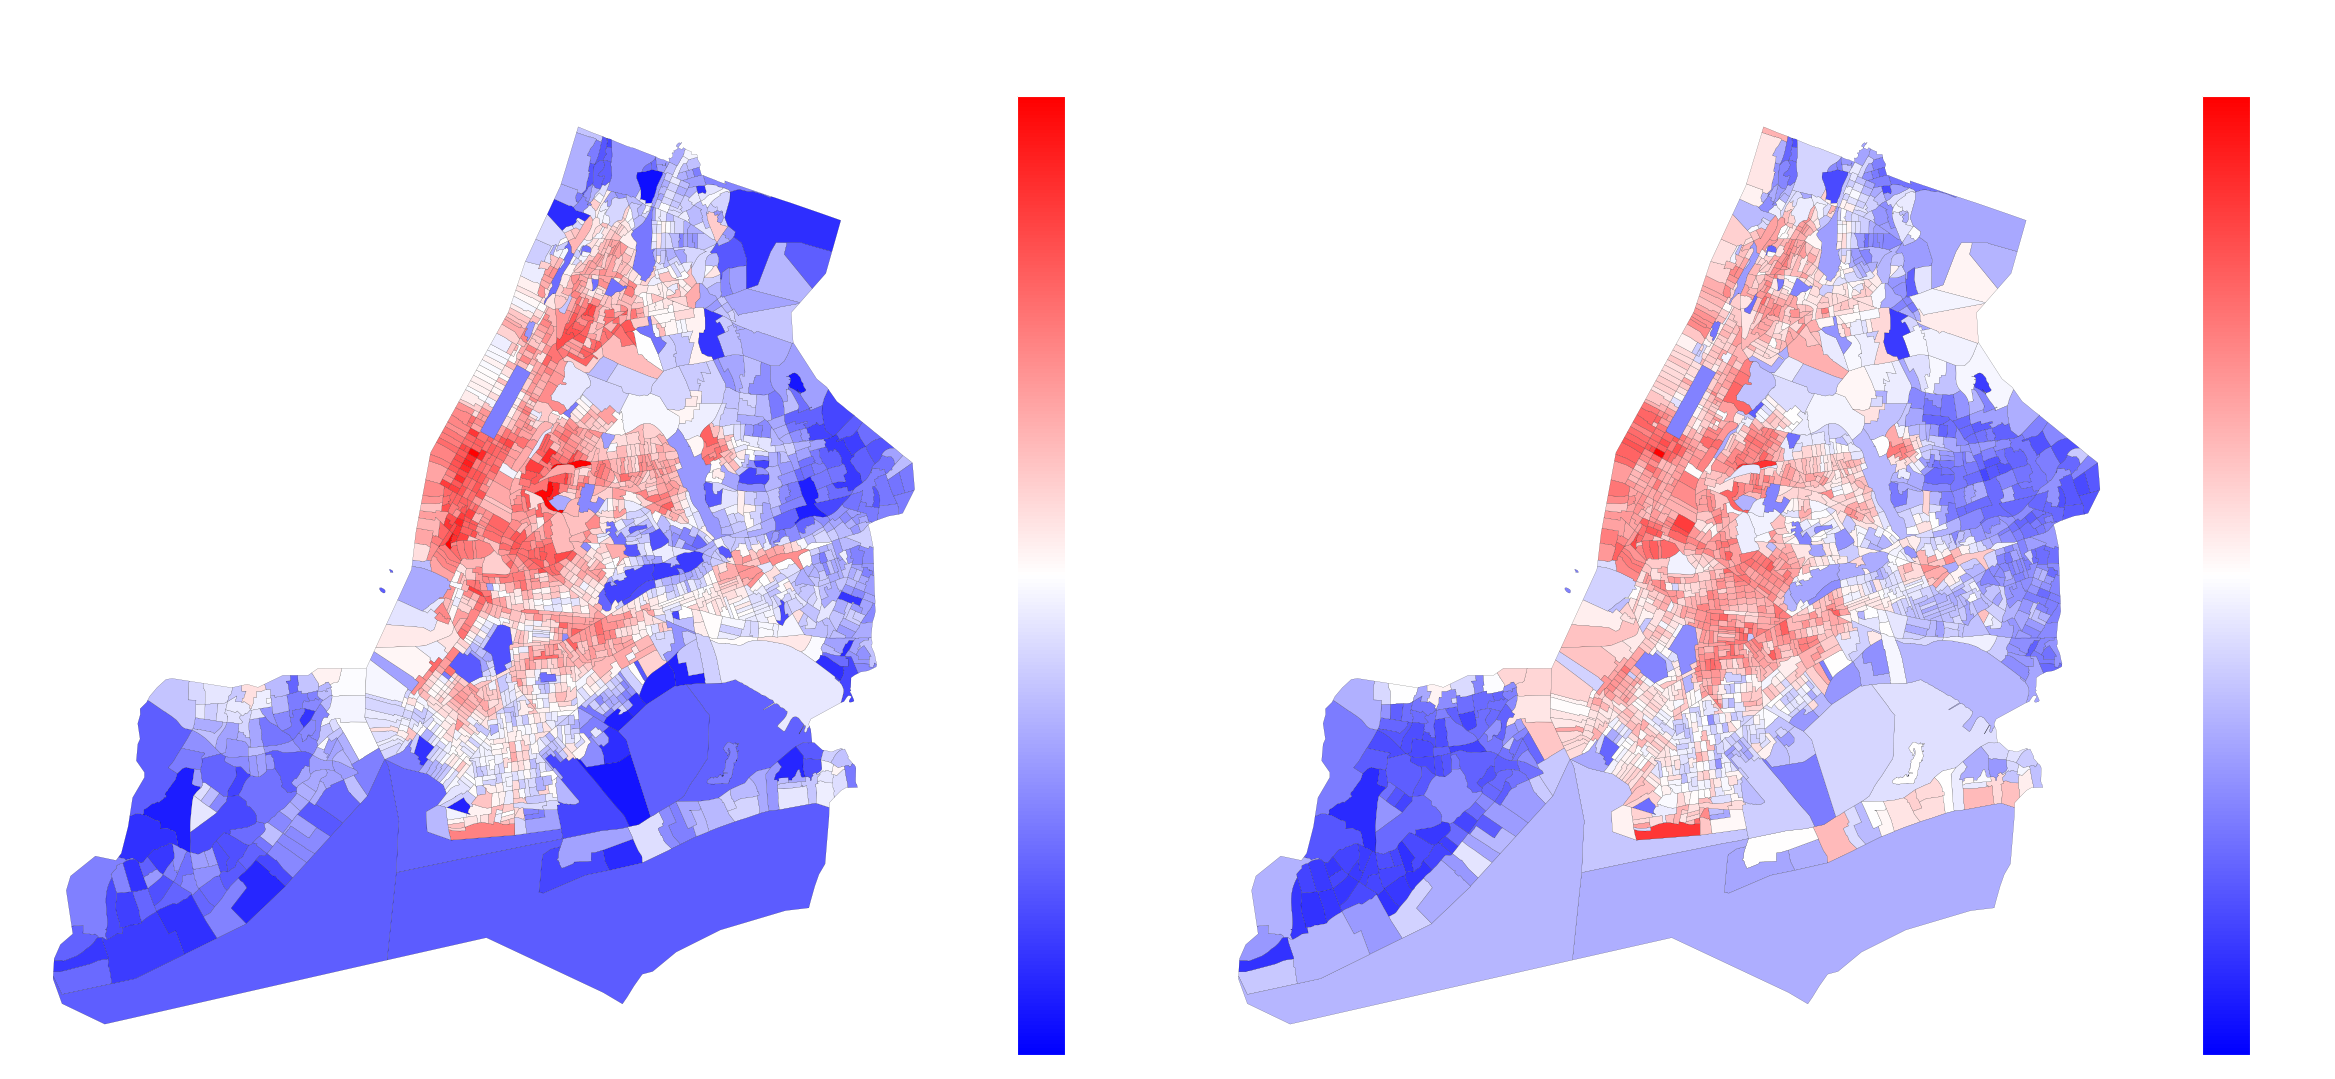

In [6]:
# Create Summer vs Winter LRS Comparison Map
from matplotlib.colors import LinearSegmentedColormap

fig, axes = plt.subplots(1, 2, figsize=(24, 14))
fig.patch.set_alpha(0)  # Transparent figure background

# Custom colormap: pure RGB blue → white → pure RGB red
colors = ['#0000FF', '#FFFFFF', '#FF0000']  # Blue → White → Red
custom_cmap = LinearSegmentedColormap.from_list('rgb_bwr', colors)

# Hardcoded LRS range for consistent visualization
lrs_min = 0
lrs_max = 0.7

# Summer LRS
axes[0].patch.set_alpha(0)
gdf_lrs.plot(
    column='LRS_Summer',
    ax=axes[0],
    legend=True,
    cmap=custom_cmap,  # Custom RGB blue → white → red
    edgecolor='black',
    linewidth=0.1,
    vmin=lrs_min, vmax=lrs_max,
    legend_kwds={'label': 'LRS Score', 'shrink': 0.7},
    missing_kwds={'color': 'lightgrey'}
)
axes[0].set_title('Summer LRS (Jun-Aug 2023)\n0.5×LCS + 0.5×ES', fontsize=24, fontweight='bold', color='white')
axes[0].axis('off')

# Winter LRS
axes[1].patch.set_alpha(0)
gdf_lrs.plot(
    column='LRS_Winter',
    ax=axes[1],
    legend=True,
    cmap=custom_cmap,  # Same colormap for comparison
    edgecolor='black',
    linewidth=0.1,
    vmin=lrs_min, vmax=lrs_max,
    legend_kwds={'label': 'LRS Score', 'shrink': 0.7},
    missing_kwds={'color': 'lightgrey'}
)
axes[1].set_title('Winter LRS (Dec 2022 - Feb 2023)\n0.5×LCS + 0.5×ES', fontsize=24, fontweight='bold', color='white')
axes[1].axis('off')

# Style all colorbars
for i, ax in enumerate(fig.axes):
    if i >= 2:  # Colorbar axes
        ax.tick_params(colors='white', labelsize=16)
        ax.yaxis.label.set_color('white')
        ax.yaxis.label.set_fontsize(18)
        for spine in ax.spines.values():
            spine.set_color('white')

plt.tight_layout()
plt.savefig('../Pitch3/LRS_Summer_Winter_Comparison.png', dpi=300, bbox_inches='tight', transparent=True)
print("Saved: LRS_Summer_Winter_Comparison.png")
plt.show()

## 5. Three-Panel Comparison: LCS vs ES vs LRS

Saved: LRS_ThreePanel_Summer.png


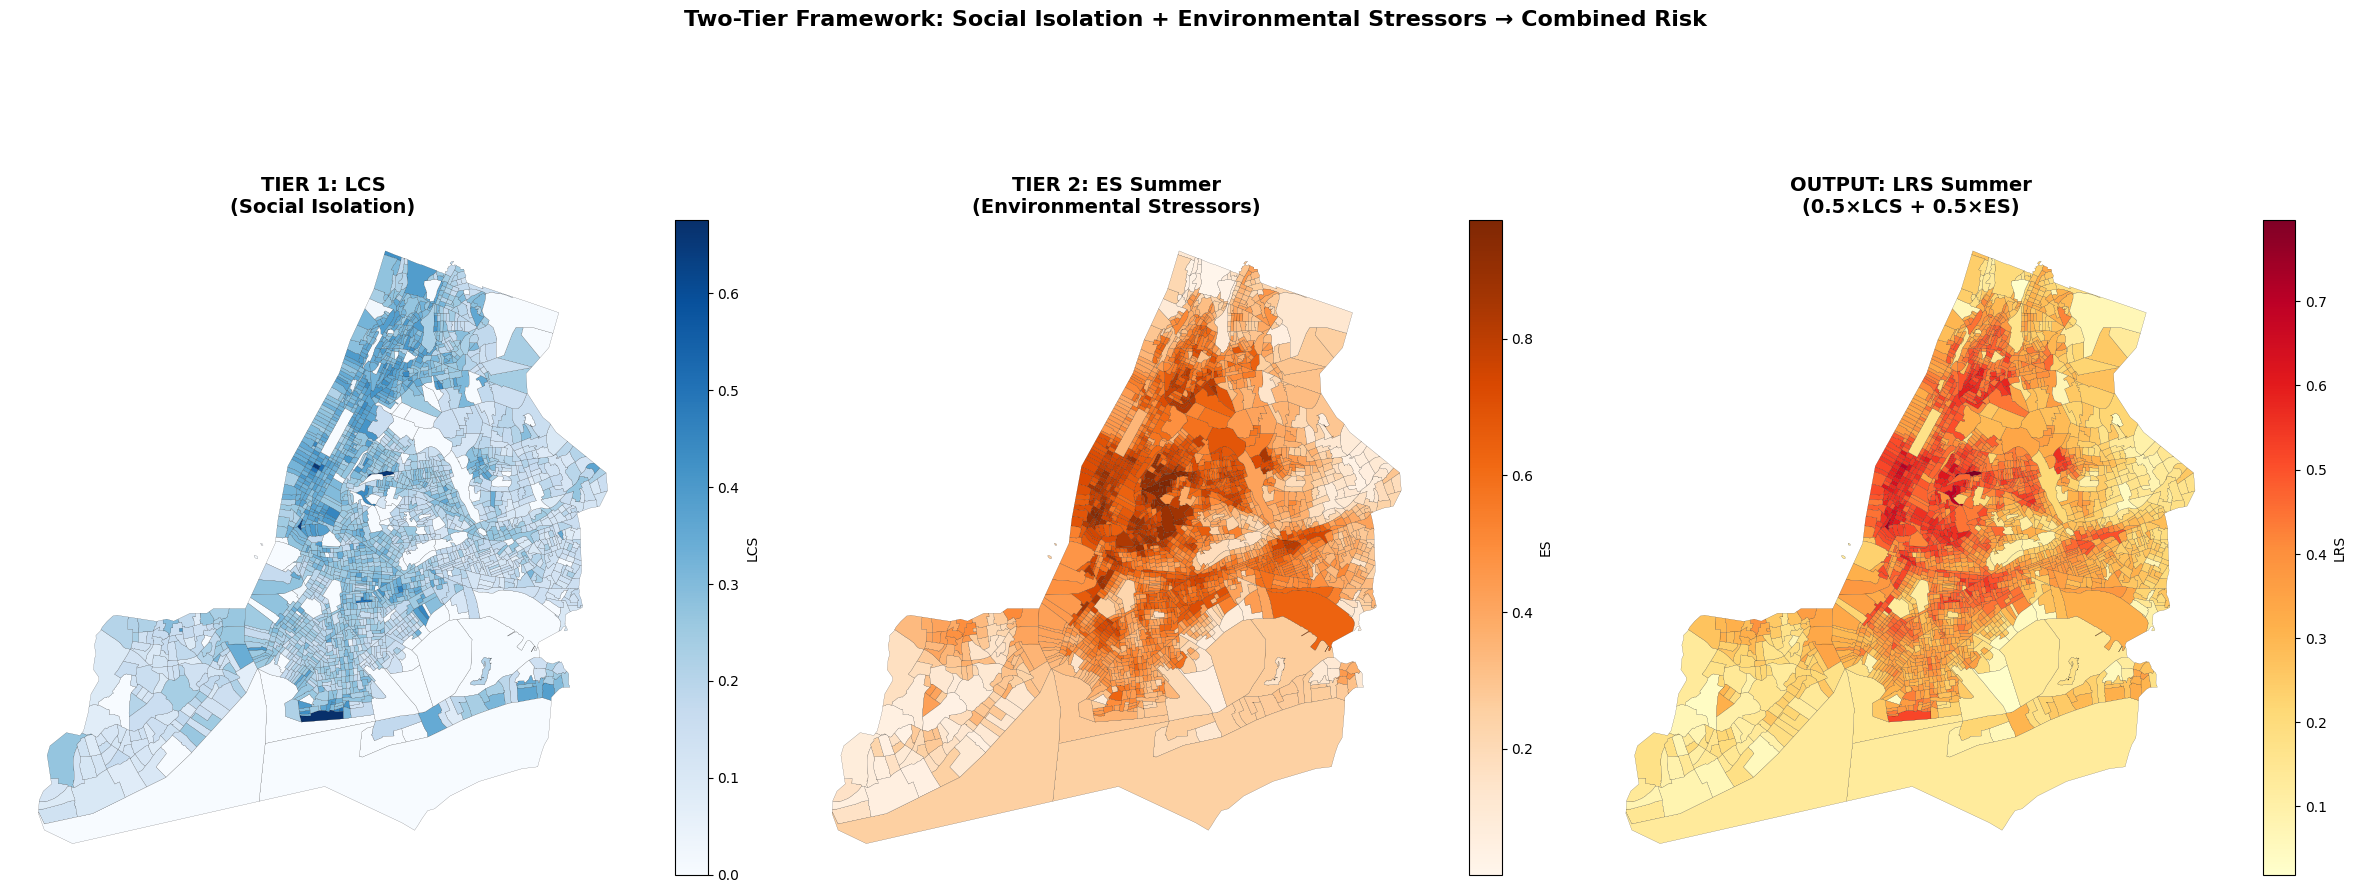

In [7]:
# Create 3-panel comparison for Summer
fig, axes = plt.subplots(1, 3, figsize=(24, 10))

# Panel 1: LCS (Social Isolation)
gdf_lrs.plot(
    column='LCS',
    ax=axes[0],
    legend=True,
    cmap='Blues',
    edgecolor='black',
    linewidth=0.1,
    legend_kwds={'label': 'LCS', 'shrink': 0.7},
    missing_kwds={'color': 'lightgrey'}
)
axes[0].set_title('TIER 1: LCS\n(Social Isolation)', fontsize=14, fontweight='bold')
axes[0].axis('off')

# Panel 2: ES Summer (Environmental Stressors)
gdf_lrs.plot(
    column='ES_Summer',
    ax=axes[1],
    legend=True,
    cmap='Oranges',
    edgecolor='black',
    linewidth=0.1,
    legend_kwds={'label': 'ES', 'shrink': 0.7},
    missing_kwds={'color': 'lightgrey'}
)
axes[1].set_title('TIER 2: ES Summer\n(Environmental Stressors)', fontsize=14, fontweight='bold')
axes[1].axis('off')

# Panel 3: LRS Summer (Combined)
gdf_lrs.plot(
    column='LRS_Summer',
    ax=axes[2],
    legend=True,
    cmap='YlOrRd',
    edgecolor='black',
    linewidth=0.1,
    legend_kwds={'label': 'LRS', 'shrink': 0.7},
    missing_kwds={'color': 'lightgrey'}
)
axes[2].set_title('OUTPUT: LRS Summer\n(0.5×LCS + 0.5×ES)', fontsize=14, fontweight='bold')
axes[2].axis('off')

plt.suptitle('Two-Tier Framework: Social Isolation + Environmental Stressors → Combined Risk', 
             fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('../Pitch3/LRS_ThreePanel_Summer.png', dpi=300, bbox_inches='tight')
print("Saved: LRS_ThreePanel_Summer.png")
plt.show()

## 6. Priority Zone Classification (Quadrant Analysis)

In [8]:
# Classify tracts into quadrants based on LCS and ES
# Using median as threshold

lcs_median = gdf_lrs['LCS'].median()
es_summer_median = gdf_lrs['ES_Summer'].median()
es_winter_median = gdf_lrs['ES_Winter'].median()

print(f"LCS median: {lcs_median:.3f}")
print(f"ES Summer median: {es_summer_median:.3f}")
print(f"ES Winter median: {es_winter_median:.3f}")

# Summer quadrants
def classify_quadrant(row, es_col, es_median):
    high_lcs = row['LCS'] >= lcs_median
    high_es = row[es_col] >= es_median
    
    if high_lcs and high_es:
        return 'PRIORITY (High LCS + High ES)'
    elif high_lcs and not high_es:
        return 'Social Programs (High LCS)'
    elif not high_lcs and high_es:
        return 'Infrastructure (High ES)'
    else:
        return 'Monitor (Low Risk)'

gdf_lrs['Quadrant_Summer'] = gdf_lrs.apply(lambda row: classify_quadrant(row, 'ES_Summer', es_summer_median), axis=1)
gdf_lrs['Quadrant_Winter'] = gdf_lrs.apply(lambda row: classify_quadrant(row, 'ES_Winter', es_winter_median), axis=1)

print("\nSummer Quadrant Distribution:")
print(gdf_lrs['Quadrant_Summer'].value_counts())

print("\nWinter Quadrant Distribution:")
print(gdf_lrs['Quadrant_Winter'].value_counts())

LCS median: 0.234
ES Summer median: 0.501
ES Winter median: 0.523

Summer Quadrant Distribution:
Quadrant_Summer
PRIORITY (High LCS + High ES)    748
Monitor (Low Risk)               747
Infrastructure (High ES)         416
Social Programs (High LCS)       416
Name: count, dtype: int64

Winter Quadrant Distribution:
Quadrant_Winter
PRIORITY (High LCS + High ES)    759
Monitor (Low Risk)               758
Infrastructure (High ES)         405
Social Programs (High LCS)       405
Name: count, dtype: int64


Saved: LRS_Priority_Zones.png


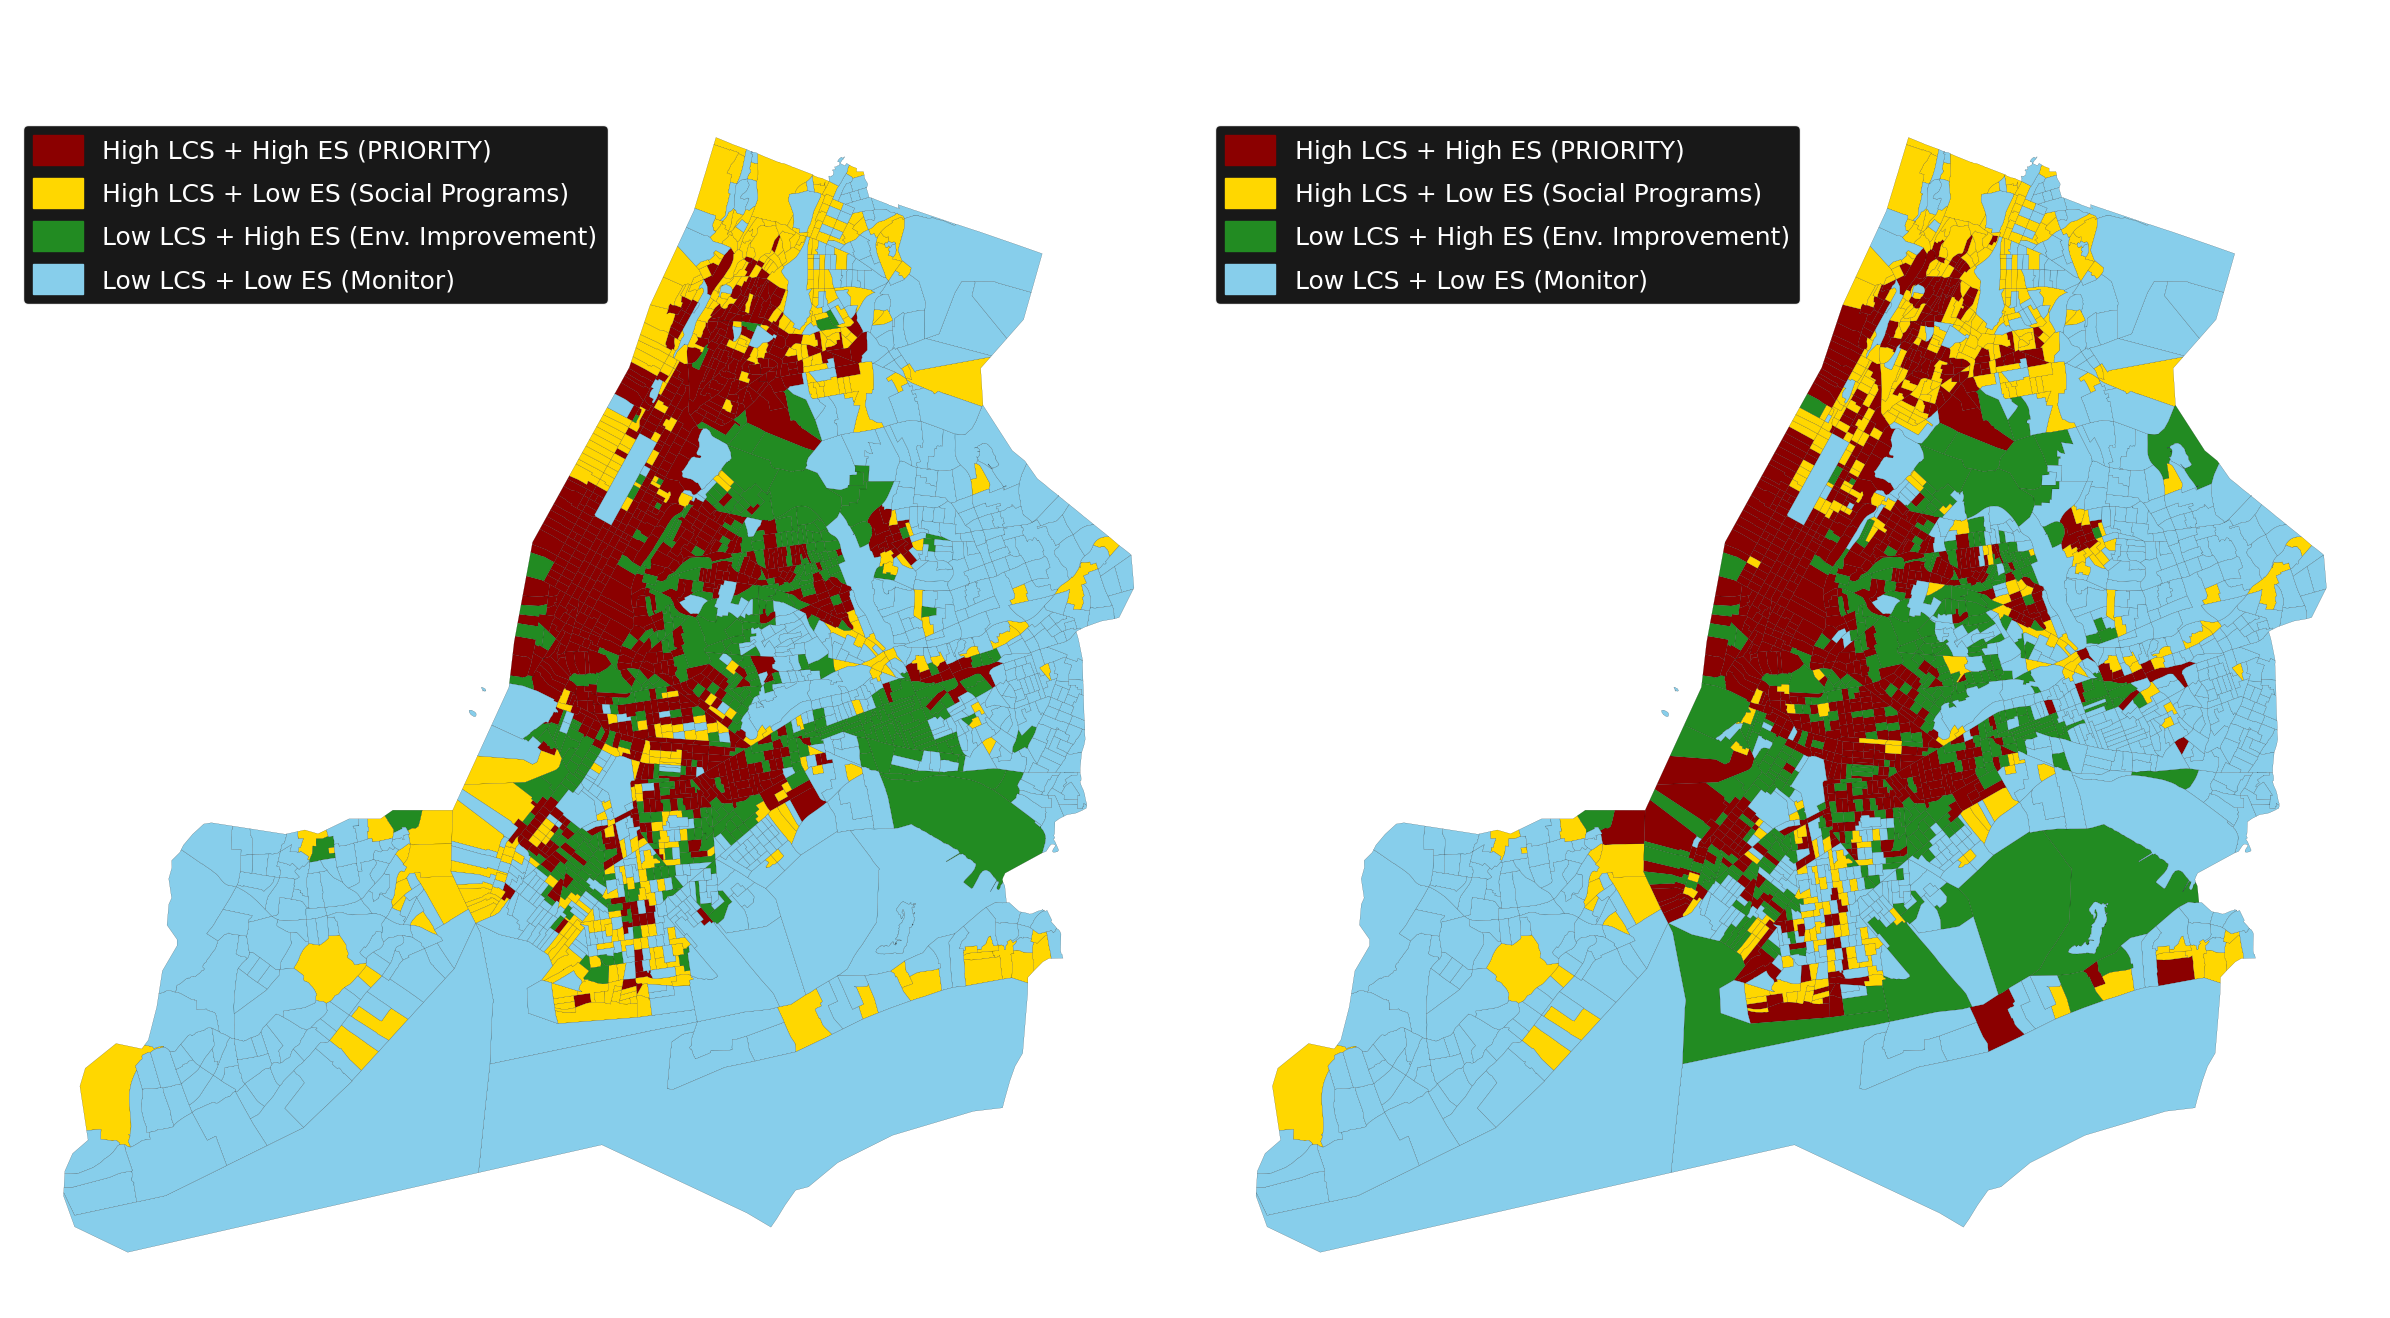

In [14]:
# Create Quadrant Map
import matplotlib.patches as mpatches

fig, axes = plt.subplots(1, 2, figsize=(24, 14))
fig.patch.set_alpha(0)  # Transparent figure background

# Color mapping for quadrants - Option 1: Traffic Light Extended (with Blue/Green swapped)
quadrant_colors = {
    'High LCS + High ES (PRIORITY)': '#8B0000',      # Dark Red/Maroon - Critical
    'High LCS + Low ES (Social Programs)': '#FFD700', # Gold/Amber - High
    'Low LCS + High ES (Env. Improvement)': '#228B22',  # Green - Moderate
    'Low LCS + Low ES (Monitor)': '#87CEEB'           # Sky Blue - Low
}

# Mapping from old names to new names
name_mapping = {
    'PRIORITY (High LCS + High ES)': 'High LCS + High ES (PRIORITY)',
    'Social Programs (High LCS)': 'High LCS + Low ES (Social Programs)',
    'Infrastructure (High ES)': 'Low LCS + High ES (Env. Improvement)',
    'Monitor (Low Risk)': 'Low LCS + Low ES (Monitor)'
}

# Create categorical order
category_order = ['High LCS + High ES (PRIORITY)', 'High LCS + Low ES (Social Programs)', 
                  'Low LCS + High ES (Env. Improvement)', 'Low LCS + Low ES (Monitor)']

# Summer quadrants
axes[0].patch.set_alpha(0)
for old_cat, new_cat in name_mapping.items():
    gdf_lrs[gdf_lrs['Quadrant_Summer'] == old_cat].plot(
        ax=axes[0],
        color=quadrant_colors[new_cat],
        edgecolor='black',
        linewidth=0.1
    )
axes[0].set_title('Summer Priority Zones\n(Jun-Aug 2023)', fontsize=24, fontweight='bold', color='white')
axes[0].axis('off')

# Winter quadrants
axes[1].patch.set_alpha(0)
for old_cat, new_cat in name_mapping.items():
    gdf_lrs[gdf_lrs['Quadrant_Winter'] == old_cat].plot(
        ax=axes[1],
        color=quadrant_colors[new_cat],
        edgecolor='black',
        linewidth=0.1
    )
axes[1].set_title('Winter Priority Zones\n(Dec 2022 - Feb 2023)', fontsize=24, fontweight='bold', color='white')
axes[1].axis('off')

# Create custom legend with ordered categories
legend_patches = [mpatches.Patch(color=quadrant_colors[cat], label=cat) for cat in category_order]

# Add legend to both plots (upper left, bigger font and markers)
for ax in axes:
    legend = ax.legend(handles=legend_patches, loc='upper left', fontsize=18, 
              framealpha=0.9, facecolor='black', edgecolor='white',
              labelcolor='white', bbox_to_anchor=(0, 0.975),
              handlelength=2, handleheight=1.5, markerscale=1.5)

plt.tight_layout()
plt.savefig('../Pitch3/LRS_Priority_Zones.png', dpi=300, bbox_inches='tight', transparent=True)
print("Saved: LRS_Priority_Zones.png")
plt.show()

## 7. Borough-Level Summary

In [10]:
borough_labels = {
    '005': 'Bronx',
    '047': 'Brooklyn',
    '061': 'Manhattan',
    '081': 'Queens',
    '085': 'Staten Island'
}

# Summary by borough
print("\nLRS Statistics by Borough:")
print("\n=== SUMMER ===")
summer_summary = gdf_lrs.groupby('COUNTYFP').agg({
    'LCS': ['mean', 'median'],
    'ES_Summer': ['mean', 'median'],
    'LRS_Summer': ['mean', 'median']
}).round(3)
summer_summary.index = summer_summary.index.map(borough_labels)
print(summer_summary)

print("\n=== WINTER ===")
winter_summary = gdf_lrs.groupby('COUNTYFP').agg({
    'LCS': ['mean', 'median'],
    'ES_Winter': ['mean', 'median'],
    'LRS_Winter': ['mean', 'median']
}).round(3)
winter_summary.index = winter_summary.index.map(borough_labels)
print(winter_summary)


LRS Statistics by Borough:

=== SUMMER ===
                 LCS        ES_Summer        LRS_Summer       
                mean median      mean median       mean median
COUNTYFP                                                      
Bronx          0.276  0.288     0.444  0.445      0.360  0.367
Brooklyn       0.231  0.235     0.531  0.521      0.381  0.380
Manhattan      0.320  0.324     0.630  0.651      0.475  0.487
Queens         0.185  0.182     0.481  0.476      0.333  0.326
Staten Island  0.154  0.141     0.254  0.267      0.204  0.204

=== WINTER ===
                 LCS        ES_Winter        LRS_Winter       
                mean median      mean median       mean median
COUNTYFP                                                      
Bronx          0.276  0.288     0.434  0.451      0.355  0.372
Brooklyn       0.231  0.235     0.582  0.586      0.406  0.412
Manhattan      0.320  0.324     0.596  0.598      0.458  0.465
Queens         0.185  0.182     0.457  0.471      0.321  0

In [11]:
# Priority zones by borough
print("\nPriority Zones by Borough:")
print("\n=== SUMMER ===")
priority_summer = gdf_lrs.groupby(['COUNTYFP', 'Quadrant_Summer']).size().unstack(fill_value=0)
priority_summer.index = priority_summer.index.map(borough_labels)
print(priority_summer)

print("\n=== WINTER ===")
priority_winter = gdf_lrs.groupby(['COUNTYFP', 'Quadrant_Winter']).size().unstack(fill_value=0)
priority_winter.index = priority_winter.index.map(borough_labels)
print(priority_winter)


Priority Zones by Borough:

=== SUMMER ===
Quadrant_Summer  Infrastructure (High ES)  Monitor (Low Risk)  \
COUNTYFP                                                        
Bronx                                   8                  83   
Brooklyn                              188                 209   
Manhattan                              13                  10   
Queens                                205                 336   
Staten Island                           2                 109   

Quadrant_Summer  PRIORITY (High LCS + High ES)  Social Programs (High LCS)  
COUNTYFP                                                                    
Bronx                                      130                         140  
Brooklyn                                   253                         155  
Manhattan                                  232                          55  
Queens                                     133                          51  
Staten Island                         

## 8. Top 10 Highest Risk Tracts

In [12]:
# Top 10 highest LRS tracts
print("\nTop 10 Census Tracts - Highest SUMMER Risk (LRS):")
top_summer = gdf_lrs.nlargest(10, 'LRS_Summer')[['NAMELSAD', 'COUNTYFP', 'LCS', 'ES_Summer', 'LRS_Summer']]
top_summer['Borough'] = top_summer['COUNTYFP'].map(borough_labels)
print(top_summer[['NAMELSAD', 'Borough', 'LCS', 'ES_Summer', 'LRS_Summer']].to_string())

print("\n" + "="*70)

print("\nTop 10 Census Tracts - Highest WINTER Risk (LRS):")
top_winter = gdf_lrs.nlargest(10, 'LRS_Winter')[['NAMELSAD', 'COUNTYFP', 'LCS', 'ES_Winter', 'LRS_Winter']]
top_winter['Borough'] = top_winter['COUNTYFP'].map(borough_labels)
print(top_winter[['NAMELSAD', 'Borough', 'LCS', 'ES_Winter', 'LRS_Winter']].to_string())


Top 10 Census Tracts - Highest SUMMER Risk (LRS):
                 NAMELSAD    Borough       LCS  ES_Summer  LRS_Summer
525   Census Tract 171.02     Queens  0.653880   0.939085    0.796482
1907   Census Tract 29.01  Manhattan  0.644660   0.829716    0.737188
1995     Census Tract 119  Manhattan  0.653810   0.766223    0.710016
388   Census Tract 199.02     Queens  0.442672   0.945531    0.694102
595      Census Tract 109  Manhattan  0.417976   0.897830    0.657903
1952      Census Tract 43  Manhattan  0.409453   0.889987    0.649720
391   Census Tract 199.01     Queens  0.327536   0.963580    0.645558
382    Census Tract 33.02     Queens  0.363384   0.924259    0.643821
1985      Census Tract 96  Manhattan  0.505740   0.779437    0.642588
692      Census Tract 113  Manhattan  0.503761   0.781156    0.642458


Top 10 Census Tracts - Highest WINTER Risk (LRS):
                 NAMELSAD    Borough       LCS  ES_Winter  LRS_Winter
1995     Census Tract 119  Manhattan  0.653810   0.742587

## 9. Save Final Data

In [13]:
# Save LRS data as GeoJSON
output_cols = ['GEOID', 'NAMELSAD', 'COUNTYFP', 
               'LCS', 'ES_Summer', 'ES_Winter', 
               'LRS_Summer', 'LRS_Winter',
               'Quadrant_Summer', 'Quadrant_Winter',
               'geometry']

gdf_lrs[output_cols].to_file('../Pitch3/LRS_NYC_2023.geojson', driver='GeoJSON')
print("Saved: LRS_NYC_2023.geojson")

# CSV for easy analysis
csv_cols = [c for c in output_cols if c != 'geometry']
gdf_lrs[csv_cols].to_csv('../Pitch3/LRS_NYC_2023.csv', index=False)
print("Saved: LRS_NYC_2023.csv")

Saved: LRS_NYC_2023.geojson
Saved: LRS_NYC_2023.csv


---
## Summary

### Two-Tier Framework
```
TIER 1: LCS (Loneliness Composite Score)
  - 6 census-based factors
  - Literature-based weights
                    ↓
TIER 2: ES (Environmental Stressors)  
  - 4 satellite-derived factors
  - Equal weighting (0.25 each)
                    ↓
OUTPUT: LRS = 0.5×LCS + 0.5×ES
  - Summer and Winter versions
  - Priority zone classification
```

### Key Outputs
- `LRS_Summer_Winter_Comparison.png`: Side-by-side seasonal maps
- `LRS_ThreePanel_Summer.png`: LCS → ES → LRS visualization
- `LRS_Priority_Zones.png`: Quadrant-based intervention zones
- `LRS_NYC_2023.geojson`: Final data for mapping
- `LRS_NYC_2023.csv`: Tabular data for analysis